# Обучение модели классификации комментариев

**Задача**

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Необходимо обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Условие**

Метрика качества *F1* должна быть не меньше 0.75.

**Краткий план действий**

1. Загрузка и предобработка данных.
2. Подготовка корпуса текстов:
   - очистка
   - токенизация
   - лемматизация
   - векторизация
3. Обучение моделей классификации.
4. Тестирование оптимальной модели.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
# импортируем необходимые библиотеки и модули

!/opt/conda/bin/python -m pip install wordcloud
!pip install --upgrade Pillow==9.5.0

import numpy as np
import pandas as pd
import lightgbm as lgb
import nltk
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet

from wordcloud import WordCloud

nltk.download('averaged_perceptron_tagger')

from tqdm.notebook import tqdm
tqdm.pandas()

warnings.filterwarnings("ignore", category=ConvergenceWarning)
pd.set_option('display.max_colwidth', 500)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# загружаем данные
data = pd.read_csv('/datasets/toxic_comments.csv')
data.head()

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess t...",0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


### Осмотр и предобработка данных

In [ ]:
print("Количество строк в датасете:",len(data))

Количество строк в датасете: 159292


Выведем общую информацию о датасете:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Удалим неинформативный столбец:

In [ ]:
data = data.drop('Unnamed: 0',axis=1)

Проверим датасет на наличие пропусков и дубликатов:

In [ ]:
print('Количество пропусков:')
print(data.isna().sum())
print('')
print('Количество явных дубликатов',data.duplicated().sum())

Количество пропусков:
text     0
toxic    0
dtype: int64

Количество явных дубликатов 0


Посмотрим на соотношение классов классов в датасете:

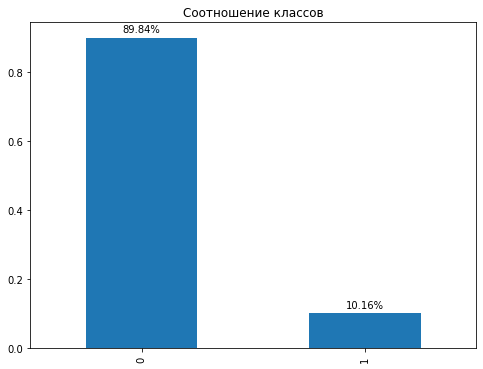

In [ ]:
data['toxic'].value_counts(normalize=True).plot(kind='bar', figsize=(8,6))
plt.title('Соотношение классов')

# добавим подписи к барам
for i, value in enumerate(data['toxic'].value_counts(normalize=True)):
    plt.text(i, value + 0.01, f'{value:.2%}', ha='center', va='bottom')

plt.show()

Соотношение классов далеко от сблансированного ~ 90/10.

### Очистка данных

Выведем 10 рандомных комментариев:

In [ ]:
data.sample(n=10, random_state=123)

,text,toxic
86912,"It's very racist as well. But then, Schwarzenegger never made a good movie.",0
130370,"""\n Let me be clear. """"No more Mr. Nice Guy,"""" your fellow ideological partisan who you often coordinate edits and reverts with, reverted me here . I restored it and he reverted me again here . So far you're just backing your ideological comrade on this talk page. But you stand at the ready with support. Y'all are masters at gaming the whole website to play a propaganda game? Good faith. I'm a grown man and I've observed your behavior long enough. Assumptions of good faith get replaced by re...",0
143172,"OK, no one's edited this talk page in 5.5 years, so I'm just going to change it. (t • c)",0
79735,""":: I went ahead and posted it on there. (contribs) \n\n""",0
131398,Hi\nI'm also from Northern Ireland ),0
116040,"""\n I've explained why the unblock should occur. !! a Punk !! """,0
57040,"""\nNice to see this settled. Happy editing and make sure its accurate. ;) Faiz """,0
119137,"""\n\n Sir etc in sequence \n\nSame goes for Lord/Lady (""""Dr. Lady Jane Poshname"""") or Hon. (""""Maj. Hon. James Bellamy""""), right? — """,0
54762,"Your userboxes\nI've removed two of your userboxes which claim, apparently falsely, that 1) you are female and that 2) you serve in the British Army. 67.170.87.223 \nPer your reversion, will you kindly address this inquiry.67.170.87.223",0
68828,"""\n\nLone boatman, it is you who have willfully and repeatedly violated Wikipedia's policies by making entire changes to the 'eternity clause' article then threatening me as usual. And you ask me now to stay """"cool"""" as you continue to manipulate editors and possible administrators to cover your wrongdoings. Oh, I am staying """"cool"""". You know full and well that I am staying """"cool"""". If I was not cool I would have deleted your last changes. It is you who made the last changes, not me. Hopef...",0


Необходимо привести комментарии к нижнему регистру и удалить ненужные символы:

In [ ]:
# приведем все к нижнему регистру
data['text'] = data['text'].str.lower()

In [ ]:
# очистим датасет от ненужных символов
data['text'] = data['text'].str.replace('[^a-zA-Z]', ' ')
data.sample(5)

/tmp/ipykernel_287/2671765685.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['text'] = data['text'].str.replace('[^a-zA-Z]', ' ')


,text,toxic
120410,the answer is as usual it depends but with these cleanup templates a number of bots add the date parameter so the extra work is negligable and having the bots do it means you don t get things like devember as i typed earlier today or more subtley december lower case d also if you add a named parameter to a template and it is unused it doesn t matter as you hint above farmbrough december gmt,0
42932,thanks for the heads up asshole,1
39925,i didn t say they weren t dodgy i hate demountables as a rule this doesn t alter the fact that they remain as an important part of chs history as for your objection to the word permanent you might also be aware that until recently the entire school was scheduled to be levelled to make way for unit blocks with all the students to be relocated to the kuringai college site this was only avoided by the re routing of the epping chatswood railway nothing is permanent by those ...,0
106814,i only posted facts i never wrote he is the worst player etc i posted facts explain how that is bias damn i m sick of these complaints and deletion of my posts i never deleted any kobe rape crap did you see me delete that i might have added though he was not found guilty but i never deleted that stuff and if i did i didn t do it over and over again now people delete some stuff off mvp candidacy for him over and over again damn you guys are horrible and so are some of the admins on...,1
8599,how civil is this who the fuck do you think you are to but in on a conversation between old friends you cunt,1


### Токенизация

Разделим корпус текстов на токены с помощью функции **word_tokenize** библиотеки nltk:

In [ ]:
# приведем тексты к типу str
data['text'] = data['text'].astype(str)

In [ ]:
# загрузим стоп-слова
stop_words = set(stopwords.words('english'))

# токенизация с фильтрацией стоп-слов
data['tokenized_text'] = data['text'].progress_apply(lambda x: [token for token in word_tokenize(x)
                                                                if token not in stop_words])

  0%|          | 0/159292 [00:00<?, ?it/s]

In [ ]:
data.head()

,text,toxic,tokenized_text
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]"
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]"
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there...,0,"[make, real, suggestions, improvement, wondered, section, statistics, later, subsection, types, accidents, think, references, may, need, tidying, exact, format, ie, date, format, etc, later, one, else, first, preferences, formatting, style, references, want, please, let, know, appears, backlog, articles, review, guess, may, delay, reviewer, turns, listed, relevant, form, eg, wikipedia, good, article, nominations, transport]"
4,you sir are my hero any chance you remember what page that s on,0,"[sir, hero, chance, remember, page]"


### Лемматизация

Лемматизируем токенизированные тексты с помощью функции **WordNetLemmatizer** библиотеки nltk:

In [ ]:
# лемматизатор
lemmatizer = WordNetLemmatizer()

# функция для преобразования POS-тегов
def pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# определим POS-тег для каждого токена
pos_tagged_texts = data['tokenized_text'].progress_apply(lambda tokens: nltk.pos_tag(tokens))

# примененим функцию к POS-тегам
data['wordnet_tags'] = pos_tagged_texts.progress_apply(lambda x: [(word, pos_tagger(tag)) for word, tag in x])

# лемматизация с учетом POS-тегов
data['lemmatized_with_pos'] = data['wordnet_tags'].progress_apply(lambda x: [lemmatizer.lemmatize(word, tag)
                                                                  if tag else word for word, tag in x])

data.head()

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

  0%|          | 0/159292 [00:00<?, ?it/s]

,text,toxic,tokenized_text,wordnet_tags,lemmatized_with_pos
0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,0,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]","[(explanation, n), (edits, n), (made, v), (username, a), (hardcore, n), (metallica, n), (fan, n), (reverted, v), (vandalisms, a), (closure, n), (gas, n), (voted, v), (new, a), (york, n), (dolls, n), (fac, a), (please, n), (remove, v), (template, n), (talk, n), (page, n), (since, None), (retired, v)]","[explanation, edits, make, username, hardcore, metallica, fan, revert, vandalisms, closure, gas, vote, new, york, doll, fac, please, remove, template, talk, page, since, retire]"
1,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,0,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]","[(aww, n), (matches, n), (background, None), (colour, n), (seemingly, r), (stuck, a), (thanks, n), (talk, v), (january, a), (utc, n)]","[aww, match, background, colour, seemingly, stuck, thanks, talk, january, utc]"
2,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,0,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]","[(hey, n), (man, n), (really, r), (trying, v), (edit, n), (war, n), (guy, n), (constantly, r), (removing, v), (relevant, a), (information, n), (talking, v), (edits, n), (instead, r), (talk, v), (page, n), (seems, v), (care, a), (formatting, v), (actual, a), (info, n)]","[hey, man, really, try, edit, war, guy, constantly, remove, relevant, information, talk, edits, instead, talk, page, seem, care, format, actual, info]"
3,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there...,0,"[make, real, suggestions, improvement, wondered, section, statistics, later, subsection, types, accidents, think, references, may, need, tidying, exact, format, ie, date, format, etc, later, one, else, first, preferences, formatting, style, references, want, please, let, know, appears, backlog, articles, review, guess, may, delay, reviewer, turns, listed, relevant, form, eg, wikipedia, good, article, nominations, transport]","[(make, v), (real, a), (suggestions, n), (improvement, n), (wondered, v), (section, n), (statistics, n), (later, r), (subsection, v), (types, n), (accidents, n), (think, v), (references, n), (may, None), (need, v), (tidying, v), (exact, a), (format, a), (ie, n), (date, n), (format, n), (etc, n), (later, r), (one, None), (else, r), (first, a), (preferences, n), (formatting, v), (style, n), (references, n), (want, v), (please, a), (let, v), (know, v), (appears, v), (backlog, a), (articles, n),...","[make, real, suggestion, improvement, wonder, section, statistic, later, subsection, type, accident, think, reference, may, need, tidy, exact, format, ie, date, format, etc, later, one, else, first, preference, format, style, reference, want, please, let, know, appear, backlog, article, review, guess, may, delay, reviewer, turn, list, relevant, form, eg, wikipedia, good, article,

Посмотрим на слова, наиболее часто встречающиеся в токсичных и нетоксичных комментариях. Создадим облако слов для токсичных комментариев:

  0%|          | 0/16186 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

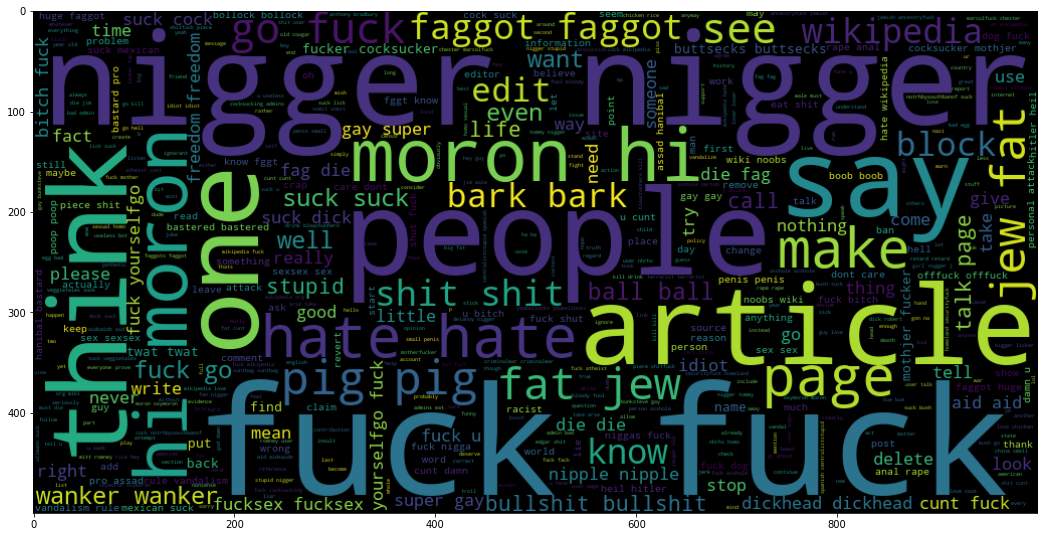

In [ ]:
plt.figure(figsize=(18,18))
text = ' '.join(data[data['toxic']==1]['lemmatized_with_pos'].progress_apply(lambda x: ' '.join(x)).values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show

Без комментариев) Теперь посмотрим на самые популярные слова в нетоксичных комментариях:

  0%|          | 0/143106 [00:00<?, ?it/s]

<function matplotlib.pyplot.show(close=None, block=None)>

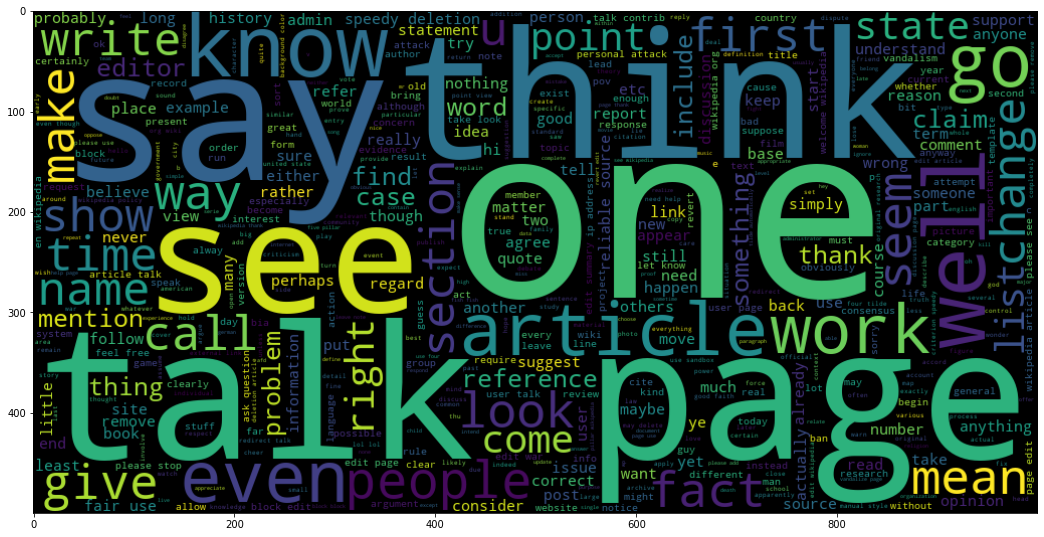

In [ ]:
plt.figure(figsize=(18,18))
text = ' '.join(data[data['toxic']==0]['lemmatized_with_pos'].progress_apply(lambda x: ' '.join(x)).values)
WC = WordCloud(width=1000, height=500, max_words=500, min_font_size=5)
cloud = WC.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.show

### Формирование выборок

Разделим данные на обучающую и тестовую выборки, с помощью параметра `stratify` сохраним баланс классов:

In [ ]:
features_train, features_test, target_train, target_test = train_test_split(data['lemmatized_with_pos'],
                                                                            data['toxic'],
                                                                            stratify = data['toxic'],
                                                                            test_size=0.2,
                                                                            random_state=123)

print(features_train.shape)
print(features_test.shape)
print('')
print('Соотношение классов в тестовой выборке:')
print(target_test.value_counts(normalize=True))

(127433,)
(31859,)

Соотношение классов в тестовой выборке:
0    0.898396
1    0.101604
Name: toxic, dtype: float64


### Векторизация текста

Для векторизации текста будем использовать функцию **TfidfVectorizer**:

In [ ]:
# приведем данные к нужному типу
features_train_str = features_train.apply(lambda x: ' '.join(x))
features_test_str = features_test.apply(lambda x: ' '.join(x))

# векторизируем тексты в обучающей и тестовой выборках
vect = TfidfVectorizer(min_df=0.0001)

features_train = vect.fit_transform(features_train_str)
features_test = vect.transform(features_test_str)

print(features_train.shape)
print(features_test.shape)

(127433, 13324)
(31859, 13324)


## Обучение

### Logistic Regression

Создадим пайплайн для логистической регрессии. С помощью GridSearch подберем оптимальное значение гиперпапараметра "С" и число n-грамм

In [ ]:
lr = LogisticRegression(solver="saga",
                           random_state=123,
                           max_iter=300)

params = {'model__C' : [3, 5, 7, 9, 11, 14],
          'tfidf__ngram_range': [(1, 1), (1, 2)]}

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=0.0001)),
    ('model',lr)])

grid = GridSearchCV(pipeline, cv=5, param_grid=params ,scoring='f1')
grid = grid.fit(features_train_str, target_train)

print("Оптимальные параметры:",grid.best_params_)
print("F-1 метрика логистической регрессии:", round(grid.best_score_,4))
print('')

Оптимальные параметры: {'model__C': 9, 'tfidf__ngram_range': (1, 1)}
F-1 метрика логистической регрессии: 0.7789



F1-мера логистической регрессии при обратной силе регуляризации равной 9 достигает своего максимума при заданных гиперпараметрах.

Попробуем изменить баланс классов с помощью гиперпараметра `class_weight`, проверим, улучшится ли метрика:

In [ ]:
log_reg = LogisticRegression(solver="saga",
                             random_state=123,
                             C=9,
                             max_iter=300,
                             class_weight = 'balanced')

cv_scores = cross_val_score(log_reg, features_train, target_train, cv=5, scoring='f1')

print(f"F1-метрика c параметром class_weight = balanced:", round(cv_scores.mean(),4))

F1-метрика c параметром class_weight = balanced: 0.6838


Значение F-1 меры при попытке баланса классов не улучшилось, а наоборот значительно ухудшилось.

### LGBMClassifier

Попробуем классификатор из библиотеки LightGBM. Обучим его с гиперпараметром `class_weight = 'balanced'`:

In [ ]:
%%time

lgbm_cl = lgb.LGBMClassifier(random_state = 123,
                            objective = 'binary',
                            class_weight = 'balanced')

cv_scores = cross_val_score(lgbm_cl, features_train, target_train, cv=5, scoring='f1')


print(f"F1-метрика LGBMClassifier", round(cv_scores.mean(),4))

F1-метрика LGBMClassifier 0.7396
CPU times: user 56min 7s, sys: 32.6 s, total: 56min 40s
Wall time: 56min 54s


Кросс-валидация LGBMClassifier без подбора параметров занимает достаточно много времени, а требуемый порог качества не достигнут при дефолтных параметрах. Попробуем обучить другую ансамблевую модель.

### Voting Classifier

Создадим ансамбль с помощью **VotingClassifier** из модуля sklearn.ensemble. В качестве классификаторов возьмем логистическую регрессию, наивный байесовский классификатор и случайный лес. Для двух последних моделей подберем оптимальные параметры с помощью GridSearchCV:

In [ ]:
clf1 = LogisticRegression(solver="saga", random_state=123, C=9,max_iter=300)
clf2 = MultinomialNB()
clf3 = RandomForestClassifier(random_state=123, class_weight='balanced')
eclf = VotingClassifier(estimators=[('lr', clf1),
                                    ('nb', clf2),
                                    ('rf', clf3)],
                                    voting='hard') # задаем метод голосования через большинство (hard voting)

params = {'nb__alpha' : [0.1,0.5,1,2],
          'rf__max_depth':[15,20,25]}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5, scoring='f1')
grid = grid.fit(features_train, target_train)

print("Оптимальные параметры:",grid.best_params_)
print("F-1 метрика:", round(grid.best_score_,4))
print('')

Оптимальные параметры: {'nb__alpha': 0.1, 'rf__max_depth': 15}
F-1 метрика: 0.7705



Результат хуже, чем у логистической регрессии, но выше порогового. Посмотрим на результаты каждого из классификаторов в ансамбле:

In [ ]:
for clf, label in zip([clf1, clf2, clf3, grid.best_estimator_], ['Logistic Regression',
                                                                 'Naive Bayes',
                                                                 'RandomForest',
                                                                 'Ensemble_HardVoting']):
    scores = cross_val_score(clf, features_train, target_train, cv=5, scoring='f1')
    print("F1-мера: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

F1-мера: 0.78 (+/- 0.01) [Logistic Regression]
F1-мера: 0.65 (+/- 0.01) [Naive Bayes]
F1-мера: 0.68 (+/- 0.01) [RandomForest]
F1-мера: 0.77 (+/- 0.01) [Ensemble_HardVoting]


Лучше всего с задачей классификации справляется логистическая регрессия, а худшая метрика - у наивного байесовского классификатора.

## Тестирование

### Проверка на тестовых данных

В качестве прототипа модели для нашей задачи возьмем логистическую регрессию - она показала лучший результат на кросс-валидации. Проверим ее на тестовой выборке:

In [ ]:
log_reg = LogisticRegression(solver="saga",
                             random_state=123,
                             C=9,
                             max_iter=300)

log_reg.fit(features_train, target_train)
log_reg_preds = log_reg.predict(features_test)
f1_log_reg = f1_score(target_test,log_reg_preds)

print('F-1 мера логистической регрессии на тестовой выборке:',f1_log_reg)

F-1 мера логистической регрессии на тестовой выборке: 0.7829801777170198


На тестовой выборке значение метрики логистической регрессии выше порогового. Визуализируем предсказания с помощью матрицы ошибок:

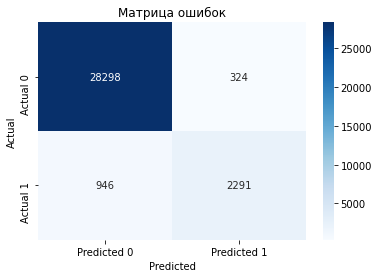

In [ ]:
cm = confusion_matrix(target_test, log_reg_preds)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Матрица ошибок')

plt.show()

Ложных присвоений статуса 'токсичности' не очень много - модель не завалит модерацию большим количеством бесполезных проверок. БОльшую часть токсичных комментариев модель детектировала, при этом примерно 30% токсичных комментариев (от всех токсичных комментариев) модель не определила.

Посмотрим, какие слова являются наиболее важными для классификации с точки зрения модели:

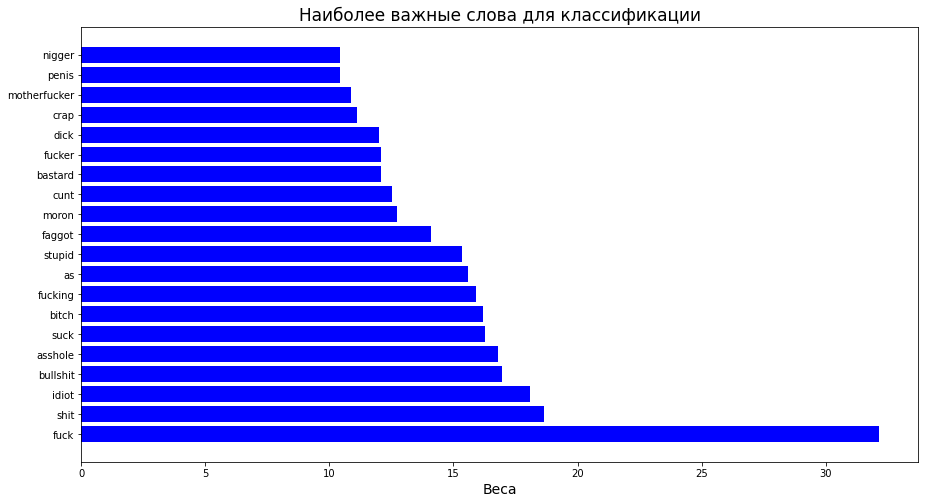

In [ ]:
# получаем коэффициенты важности
weights = log_reg.coef_.tolist()[0]

# получаем список слов из TfidfVectorizer
words = vect.get_feature_names()

# создаем словарь из слов и их весов
word_weights = dict(zip(words, weights))

# сортируем слова по абсолютному значению весов
sorted_word_weights = sorted(word_weights.items(), key=lambda x: abs(x[1]), reverse=True)

# извлекаем топ 20 слов и их весов
top_words, top_weights = zip(*sorted_word_weights[:20])

# построим график
plt.figure(figsize=(15, 8))
plt.barh(top_words, top_weights, align='center', color='blue')
plt.yticks(top_words)
plt.xlabel('Веса',size=14)
plt.title('Наиболее важные слова для классификации',size=17)
plt.show()

### Бейзлайн

В качестве бейзлайна возьмем простой дамми-классификатор, который будет предсказывать, что каждый комментарий - токсичный:

In [ ]:
dummy = DummyClassifier(random_state=123, strategy='constant', constant=1)
dummy.fit(features_train, target_train)
preds = dummy.predict(features_test)
f1 = f1_score(target_test,preds)

print("F-1 мера константной модели:", f1)

F-1 мера константной модели: 0.18446546614998857


Модель проходит проверку на адекватность, значение метрики выше константного предсказания.

## Итоговый вывод

В данном проекте нам необходимо было обучить модель классифицировать комментарии на позитивные и негативные с помощью размеченных данных. Пороговое значение метрики качества F1 - **0.75**.

На этапе подготовки корпуса нами была проведена очистка, токенизация, лемматизация и векторизация текстов.

Для исследования были взяты следующие модели:

- *Logistic Regression*
- *LGBMClassifier*
- *Voting Classifier (Logistic Regression, MultinomialNB, RandomForestClassifier)*

Лучший показатель качества на кросс-валидации показала логистическая регрессия, на тестовой выборке F1-мера составила **0.78**. Модель проходит проверку на адекватность и может быть рекомендована в качестве прототипа модели классификации комментариев. Стоит рассмотреть построение ансамбля с логистической регрессией в качестве одного из классификаторов.